In [3]:
%matplotlib inline
import numpy as np
import torch 
import math
import sys
import matplotlib.pyplot as plt 

In [6]:
import d2lzh_pytorch as d2l

# 梯度下降和随机梯度下降

## 计算公式

* 梯度下降公式：      
$$ x \leftarrow x-\eta f'(x) $$

## 一维梯度下降

In [2]:
def gd(eta):
    x=10
    results = [x]
    for i in range(10):
        x -= eta *2*x
        results.append(x)
    print('epoch 10 ,x :',x)
    return results
res = gd(0.2)

epoch 10 ,x : 0.06046617599999997


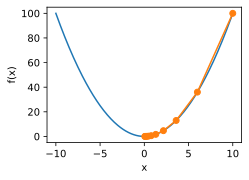

In [9]:
def show_trace(res):
    n = max(abs(min(res)),abs(max(res)),10)
    f_line = np.arange(-n,n,0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line,[x*x for x in f_line])
    d2l.plt.plot(res,[x*x for x in res],"-o")
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')
    
show_trace(res)

epoch 10 ,x : 3.4867844009999995


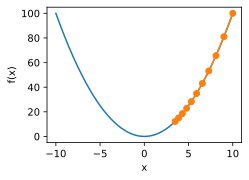

In [10]:
show_trace(gd(0.05))

epoch 10 ,x : 61.917364224000096


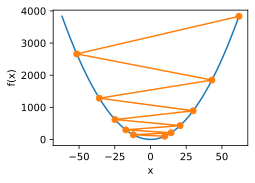

In [11]:
show_trace(gd(1.1))

## 多维梯度下降

In [17]:
def train_2d(trainer):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d ,x1 %f,x2 %f' % (i+1, x1, x2))
    return results

In [18]:
def show_trace_2d(f, results):
    d2l.plt.plot(*zip(*results), "-o", color="#ff7f0e")
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), color='#1df77d34')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20 ,x1 -0.057646,x2 -0.000073


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


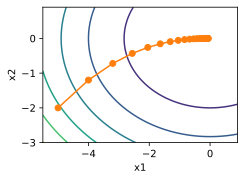

In [19]:
eta = 0.1


def f_2d(x1, x2):
    return x1**2+2*x2**2


def gd_2d(x1, x2, s1, s2):
    return (x1-eta*2*x1, x2-eta*4*x2, 0, 0)


show_trace_2d(f_2d, train_2d(gd_2d))

## 随机梯度下降

epoch 20 ,x1 0.110145,x2 0.094205


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


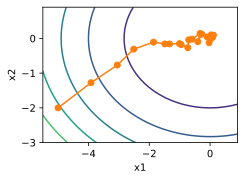

In [20]:
def sgd_2d(x1, x2, s1, s2):
    return (x1-eta*(2*x1 + np.random.normal(0.1)),
            x2-eta*(4*x2 + np.random.normal(0.1)), 0, 0)


show_trace_2d(f_2d, train_2d(sgd_2d))

# 小批量随机梯度下降

## 计算公式

* 计算公式：   

$$
\pmb{g}_t \leftarrow \nabla f_{B_t}(\pmb{x}_{t-1}) = \frac{1}{|B|}\sum \limits_{i\in{B_t}} \nabla f_i(\pmb{x}_{t-1})
$$

$$
\pmb{x}_t \leftarrow \pmb{x}_{t-1} - \eta_t \pmb{g}_t
$$

${g}_t$ 表示梯度   
${B_t}$ 指t时间的批量样本


In [28]:
%matplotlib inline
from torch import nn,optim
import time 
import numpy as np
import torch 
import math
import sys
import matplotlib.pyplot as plt 

In [29]:
import d2lzh_pytorch as d2l

In [25]:
def get_data_ch7():
    data = np.genfromtxt("airfoil_self_noise.dat",delimiter='\t')
    data = (data-data.mean(axis=0))/data.std(axis=0)
    return torch.tensor(data[:1500,:-1],dtype=torch.float32),torch.tensor(data[:1500,-1],dtype=torch.float32)

In [26]:
features,labels = get_data_ch7()

## 从零实现

In [30]:
def sgd(params,states,hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [43]:
def train_ch7(optimizer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
    net,loss = d2l.linreg,d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0,0.01,size=(features.shape[1],1)), dtype=torch.float32),requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1,dtype=torch.float32),requires_grad=True)
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features,labels),
                                            batch_size,shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l = loss(net(X,w,b),y).mean()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            
            if (batch_i+1)*batch_size % 100==0:
                ls.append(eval_loss())

    print('loss: %f, %f sec per epoch' % (ls[-1],time.time()-start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.247643, 0.022987 sec per epoch


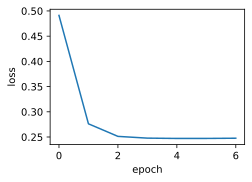

In [44]:
def train_sgd(lr,batch_size,num_epochs=2):
    train_ch7(sgd,None,{'lr':lr},features,labels,batch_size,num_epochs)
    
train_sgd(1,1500,6)

loss: 0.245203, 0.543687 sec per epoch


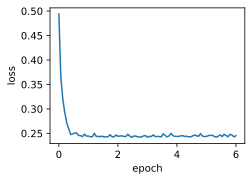

In [45]:
train_sgd(0.005,1,6)

loss: 0.245984, 0.068973 sec per epoch


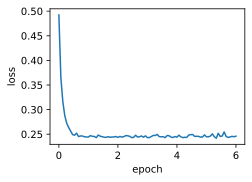

In [46]:
train_sgd(0.05,10,6)

## 简洁实现

In [49]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels, batch_size=10, num_epochs=2):
    net = nn.Sequential(
      nn.Linear(features.shape[-1],1)
    )
    loss = nn.MSELoss()

    optimizer = optimizer_fn(net.parameters(),**optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item()/2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels),
                                            batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X).view(-1), y)/2
            optimizer.zero_grad()

            l.backward()
            optimizer.step()

            if (batch_i+1)*batch_size % 100 == 0:
                ls.append(eval_loss())

    print('loss: %f, %f sec per epoch' % (ls[-1], time.time()-start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.242597, 0.102944 sec per epoch


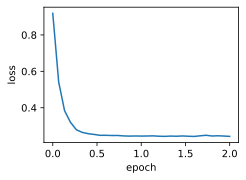

In [50]:
train_pytorch_ch7(optim.SGD,{'lr':0.05},features,labels)

# 动量法

## 计算公式

* **计算公式**：    
时间步t的⼩批量随机梯度$\pmb{g}_t$,时间步t的⾃变量
为$\pmb{x}_t$，学习率为$\eta_t$。 在时间步0,动量法创建速度变量$\pmb{v}_0$,并将其元素初始化成0。
在时间步t，动量法对每次迭代的步骤做如下修改：  

$$
\pmb{v}_t \leftarrow \gamma \pmb{v}_{t-1} + \eta_t \pmb{g}_t
$$

$$
\pmb{x}_t \leftarrow \pmb{x}_{t-1} -  \pmb{g}_t
$$

$\gamma$ 满足 $0<\gamma<1$ $\gamma=0$ 动量法等同与小批量随机梯度下降

In [72]:
eta = 0.4
def f_2d(x1,x2):
    return 0.1*x1**2+2*x2**2

def gd_2d(x1,x2,s1,s2):
    return (x1-eta*0.2*x1,x2-eta*4*x2,0,0)

epoch 20 ,x1 -0.943467,x2 -0.000073


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


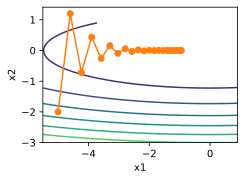

In [73]:
eta = 0.4
show_trace_2d(f_2d,train_2d(gd_2d))

epoch 20 ,x1 -0.387814,x2 -1673.365109


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


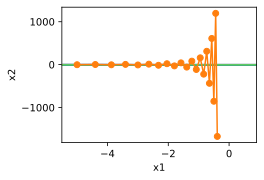

In [74]:
eta = 0.6
show_trace_2d(f_2d,train_2d(gd_2d))

epoch 20 ,x1 -0.062843,x2 0.001202


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


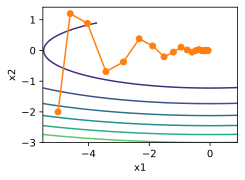

In [78]:
def momentum_2d(x1,x2,v1,v2):
    v1 = gamma * v1 + eta *0.2* x1
    v2 = gamma * v2 + eta *4* x2
    return x1-v1,x2-v2,v1,v2

eta,gamma = 0.4,0.5
show_trace_2d(f_2d,train_2d(momentum_2d))

epoch 20 ,x1 0.007188,x2 0.002553


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


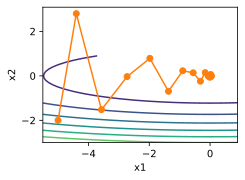

In [79]:
eta,gamma = 0.6,0.5
show_trace_2d(f_2d,train_2d(momentum_2d))
# show_trace_2d(f_2d,train_2d(sgd_2d))

## 从零实现

In [80]:
featureseat,labels = get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[-1],1),dtype=torch.float32)
    v_b = torch.zeros(1,dtype=torch.float32)
    return v_w,v_b

def sgd_momentum(param,states,hyperparams):
    for p,v in zip(param,states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

loss: 0.243965, 0.067766 sec per epoch


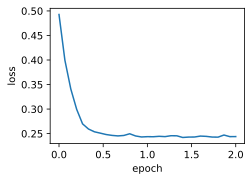

In [81]:
train_ch7(sgd_momentum,init_momentum_states(),{'lr':0.02,"momentum":0.5},features,labels)

loss: 0.257987, 0.084951 sec per epoch


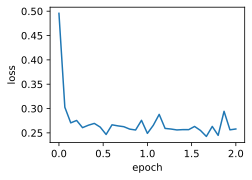

In [82]:
train_ch7(sgd_momentum,init_momentum_states(),{'lr':0.02,"momentum":0.9},features,labels)

loss: 0.242806, 0.073957 sec per epoch


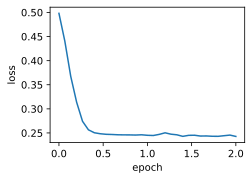

In [83]:
train_ch7(sgd_momentum,init_momentum_states(),{'lr':0.004,"momentum":0.9},features,labels)

## 简洁实现

loss: 0.244873, 0.069101 sec per epoch


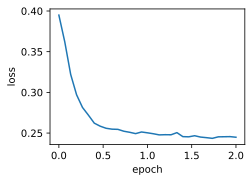

In [88]:
train_pytorch_ch7(torch.optim.SGD,{'lr':0.004,"momentum":0.9},features,labels)

# ADAGRAD

## 计算公式

* **计算公式**：    
它根据⾃变量在每个维度的梯度值的⼤⼩来调整各个维度上的学习率，从⽽避免统⼀的学习率难以适应
所有维度的问题   

$$
\pmb{s}_t \leftarrow \pmb{s}_{t-1} + \pmb{g}_t \bigodot \pmb{g}_t
$$

$$
\pmb{x}_t \leftarrow \pmb{x}_{t-1} - \frac{\eta}{\sqrt{\pmb{s}_t + \varepsilon}} \bigodot \pmb{g}_t
$$

开⽅、除法和乘法的运算都是按元素运算的

epoch 20 ,x1 -2.382563,x2 -0.158591


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


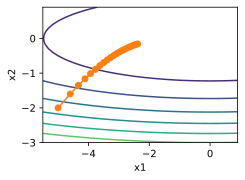

In [91]:
def adagrad_2d(x1,x2,s1,s2):
    g1,g2,eps = 0.2 * x1 ,4*x2,1e-6
    s1 += g1**2
    s2 += g2**2
    x1 -= eta/math.sqrt(s1+eps) *g1
    x2 -= eta/math.sqrt(s2+eps) *g2
    return x1,x2,s1,s2

def f_2d(x1,x2):
    return 0.1*x1**2+2*x2**2
eta = 0.4
show_trace_2d(f_2d,train_2d(adagrad_2d))

epoch 20 ,x1 -0.002295,x2 -0.000000


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


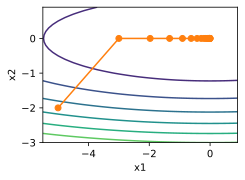

In [92]:
eta = 2
show_trace_2d(f_2d,train_2d(adagrad_2d))

## 从零实现

In [93]:
def init_adagrad_states():
    s_w = torch.zeros(features.shape[1],1,dtype=torch.float32)
    s_b = torch.zeros(1,dtype=torch.float32)
    return s_w,s_b

def adagrad(params,states,hyperparams):
    eps = 1e-6
    for p,s in zip(params,states):
        s += p.grad.data**2
        p.data -= hyperparams['lr']/torch.sqrt(s+eps) * p.grad.data
             

loss: 0.242941, 0.106939 sec per epoch


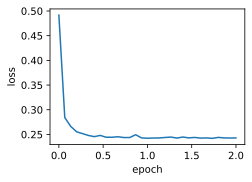

In [96]:
train_ch7(adagrad,init_adagrad_states(),{'lr':0.1},features,labels)

## 简洁实现

loss: 0.242627, 0.093757 sec per epoch


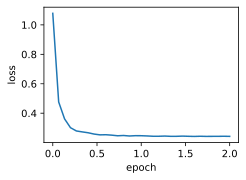

In [97]:
train_pytorch_ch7(torch.optim.Adagrad,{'lr':0.1},features,labels)

# RMSPROP

## 计算公式

* **AdaGrad做指数加权平均**

$$
\pmb{s}_t \leftarrow \gamma \pmb{s}_{t-1} + (1-\gamma)\pmb{g}_t \bigodot \pmb{g}_t
$$

$$
\pmb{x}_t \leftarrow \pmb{x}_{t-1} - \frac{\eta}{\sqrt{\pmb{s}_t + \varepsilon}} \bigodot \pmb{g}_t
$$

epoch 20 ,x1 -2.067777,x2 -0.112585


D:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'color'
  after removing the cwd from sys.path.


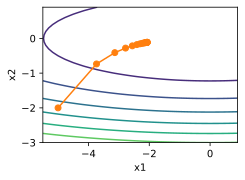

In [99]:
def rmsprop_2d(x1,x2,s1,s2):
    g1,g2 ,eps = 0.2*x1,4*x2,1e-6
    s1 += gamma * s1 + (1-gamma) * g1**2
    s2 += gamma * s2 + (1-gamma) * g2**2
    x1 -= eta * g1 /math.sqrt(s1+ eps)
    x2 -= eta * g2 /math.sqrt(s2+ eps) 
    return x1,x2,s1,s2

def f_2d(x1,x2):
    return 0.1 *x1**2 + 2*x2**2
eta,gamma=0.4,0.9
show_trace_2d(f_2d,train_2d(rmsprop_2d))

## 从零实现

In [107]:
def init_rmsprop_states():
    s_w =torch.zeros((features.shape[1],1),dtype=torch.float32)
    s_b = torch.zeros(1,dtype=torch.float32)
    return (s_w,s_b)

def rmsprop(params,states,hyperparams):
    gamma,eps =hyperparams['gamma'], 1e-6
    for p,s in zip(params,states):
        s.data = gamma * s.data + (1-gamma) * p.grad.data **2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)
    

loss: 0.245199, 0.099942 sec per epoch


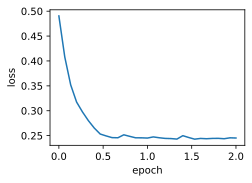

In [109]:
train_ch7(rmsprop,init_rmsprop_states(),{'lr':0.01,'gamma':0.9},features,labels)

## 简洁实现

loss: 0.243979, 0.078120 sec per epoch


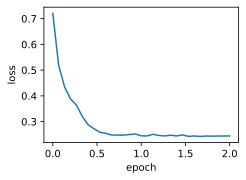

In [111]:
train_pytorch_ch7(torch.optim.RMSprop,{'lr':0.01,'alpha':0.9},features,labels)

# ADADELTA

## 计算公式

* **计算公式**：

$$
\pmb{s}_t\leftarrow\rho\pmb{s}_{t-1}+(1-\rho)\pmb{g}_t\bigodot\pmb{g}_t 
$$

$$
\pmb{g'}_t \leftarrow \sqrt{\frac{\Delta \pmb{x}_{t-1}\ + \varepsilon}{\pmb{s}_t + \varepsilon}} \bigodot\pmb{g}_t
$$

$$
\pmb{x}_t \leftarrow \pmb{x}_{t-1} - \pmb{g'}_t
$$

$$
\Delta\pmb{x}_t \leftarrow \rho\Delta\pmb{x}_{t-1} + (1-\rho)\pmb{g'}_t\bigodot\pmb{g'}_t
$$

不考虑$\varepsilon$的影响，AdaDelta算法跟RMSProp算法的不同之处在于使⽤
$\sqrt{\Delta \pmb{x}_{t-1}}$来替代学
习率 。

## 从零实现

In [120]:
def init_adadelta_states():
    s_w, s_b = torch.zeros(features.shape[1], 1, dtype=torch.float32), torch.zeros(
        1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros(
        features.shape[1], 1, dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))


def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1-rho) * (p.grad.data ** 2)
        g = p.grad.data * torch.sqrt((delta+eps)/(s+eps))
        p.data -= g
        delta[:] = rho*delta + (1-rho) * g*g

loss: 0.244261, 0.175897 sec per epoch


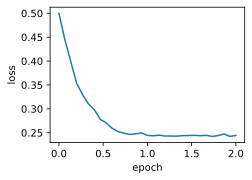

In [132]:
train_ch7(adadelta,init_adadelta_states(),{'rho':0.9},features,labels)

## 简洁实现

loss: 0.245267, 0.109936 sec per epoch


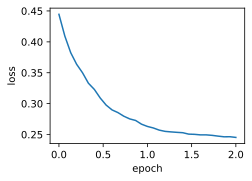

In [122]:
train_pytorch_ch7(torch.optim.Adadelta,{'rho':0.9},features,labels)

# ADAM

## 计算公式

* **计算公式**：    
动量变量$v_t$,RMSProp中按元素平⽅的指数加权移动平均变量$s_t$

$$
\pmb{v}_t \leftarrow \beta_1\pmb{v}_{t-1} + (1-\beta_1)\pmb{g}_t
$$

$$
\pmb{s}_t \leftarrow \beta_2\pmb{s}_{t-1} + (1-\beta_2)\pmb{g}_t\bigodot\pmb{g}_t
$$   
偏差修正:    
$$
\hat{\pmb{v}}_t \leftarrow \frac{\pmb{v}_t}{1-\beta_1^t}
$$

$$
\hat{\pmb{s}}_t \leftarrow \frac{\pmb{s}_t}{1-\beta_2^t}
$$ 
调整梯度

$$
\pmb{g'}_t\leftarrow \frac{\eta \hat{\pmb{v}_t}}{\sqrt{\hat{\pmb{s}_t}}+\varepsilon}
$$

$$
\pmb{x}_t \leftarrow\pmb{x}_{t-1}-\pmb{g'}_t
$$

## 从零实现

In [133]:
features,labels = get_data_ch7()
def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1),dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1),dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params,states,hyperparams):
    beta1,beta2,eps=0.9,0.999,1e-6
    for p,(v,s) in zip(params,states):
        v[:] = beta1 * v + (1-beta1) * p.grad.data
        s[:] = beta2 * s + (1-beta2) * (p.grad.data**2)
        v_bias_corr = v/(1-beta1**hyperparams['t'])
        s_bias_corr = s/(1-beta2**hyperparams['t'])   
        g = hyperparams['lr'] * v_bias_corr /(torch.sqrt(s_bias_corr) +eps)
        p.data -= g
    hyperparams['t'] +=1

loss: 0.243550, 0.141919 sec per epoch


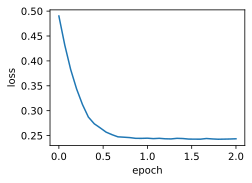

In [135]:
train_ch7(adam,init_adam_states(),{'lr':0.01,'t':1},features,labels)

## 简洁实现

loss: 0.243612, 0.098943 sec per epoch


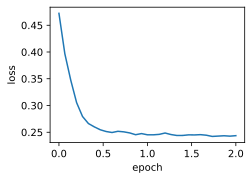

In [136]:
train_pytorch_ch7(torch.optim.Adam,{'lr':0.01},features,labels)